In this file I am using TEXT (combination of Title, Tagline and Overview) vectorized using TF-IDF for the main feature to predict Movie Genres. Following the steps I performed:
1. Preprocess the dataset deeply, since TF-IDF needs clean data to be vectorized. I dis preprocessing for both Train Dataset and Test Dataset.
2. Split the Train Dataset to be used in Modelling. It would be split into X_train, y_train, X_test, y_test.
3. Vectorize the X_train, X_test using TF-IDF.
4. Perform modelling using Random Forest, Log Regression, MLP Method.
5. So far, Log Regression give the best result either by F1 metrics or coverage-length metrics.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report



In [4]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_test.csv to cleaned_test.csv
Saving cleaned_train.csv to cleaned_train.csv


In [5]:
df_train = pd.read_csv('cleaned_train.csv')
df_test = pd.read_csv('cleaned_test.csv')

In [6]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           857 non-null    object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            1965 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

In [7]:
# Handling 'null' values
df_train['tagline'].fillna('-', inplace=True)
df_train['homepage'].fillna('-', inplace=True)


<ipython-input-7-14afae95995c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['tagline'].fillna('-', inplace=True)
<ipython-input-7-14afae95995c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [ ]:
#checkpoint
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           2386 non-null   object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            2386 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

### 1. PREPROCESS THE TEXT COLUMNS

In [8]:
!pip install unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


In [9]:
import html
import string
import unidecode
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download semua resource yang dibutuhkan
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Initialize objects
lemmatizer = WordNetLemmatizer()
default_stopwords = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = {
    'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'i',
    'movie', 'film', 'new', 'story', 'th', 'man', 'men', 'woman', 'women',
    'boy', 'girl', 'world', 'life'
}
all_stopwords = default_stopwords.union(custom_stopwords)

# Remove punctuation
punctuation_table = str.maketrans('', '', string.punctuation)

# POS tag mapper
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Main preprocessing function
def text_preprocess(sentence):
    """
    Preprocesses a single text string:
    - Removes HTML tags/entities, URLs, emails
    - Normalizes to lowercase and ASCII
    - Removes punctuation and numbers
    - Tokenizes and lemmatizes with POS tags
    - Removes stopwords and short words
    """
    if not isinstance(sentence, str) or not sentence.strip():
        return ""

    # Lowercase
    sentence = sentence.lower()

    # Remove HTML tags and entities
    sentence = html.unescape(re.sub(r'<[^>]+>', '', sentence))

    # Remove URLs and emails
    sentence = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', sentence, flags=re.MULTILINE)

    # Remove punctuation and numbers
    sentence = sentence.translate(punctuation_table)
    sentence = re.sub(r'\d+', '', sentence)

    # Normalize accents
    sentence = unidecode.unidecode(sentence)

    # Tokenize
    words = word_tokenize(sentence)

    # POS tagging
    tagged_words = pos_tag(words)

    # Lemmatization with filtering
    processed_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_words
        if word.isalpha() and word not in all_stopwords and len(word) > 2
    ]

    return ' '.join(processed_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [10]:
import pandas as pd

# Combine text
def combine_processed_text(df):
    return df['processed_title'] + ' ' + df['processed_tagline'] + ' ' + df['processed_overview']

preprocessed_data = False

if not preprocessed_data:
    for df in [df_train, df_test]:
        df['processed_title'] = df['title'].apply(lambda x: text_preprocess(str(x)) if pd.notnull(x) else '')
        df['processed_tagline'] = df['tagline'].apply(lambda x: text_preprocess(str(x)) if pd.notnull(x) else '')
        df['processed_overview'] = df['overview'].apply(lambda x: text_preprocess(str(x)) if pd.notnull(x) else '')

    df_train['text'] = combine_processed_text(df_train)
    df_test['text'] = combine_processed_text(df_test)

    df_train.to_csv('movies_genres_train_preprocessed.csv', index=False)
    df_test.to_csv('movies_genres_test_preprocessed.csv', index=False)

    preprocessed_data = True


In [11]:
##Checkpoint: The preprocessed columns

print(df_train.info())
genre_columns = df_train.columns[14:34]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2386 non-null   int64  
 1   budget              2386 non-null   float64
 2   homepage            2386 non-null   object 
 3   original_language   2386 non-null   object 
 4   original_title      2386 non-null   object 
 5   overview            2386 non-null   object 
 6   release_date        2386 non-null   object 
 7   revenue             2386 non-null   float64
 8   runtime             2386 non-null   float64
 9   status              2386 non-null   object 
 10  tagline             2386 non-null   object 
 11  title               2386 non-null   object 
 12  vote_average        2386 non-null   float64
 13  vote_count          2386 non-null   float64
 14  Action              2386 non-null   int64  
 15  Adventure           2386 non-null   int64  
 16  Animat

### 2. SPLITTING THE TRAIN DATASET (with Text as features)

In [12]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.6 MB/s eta 0:00:00


In [13]:
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

# Feature
X = df_train['text'].values.reshape(-1, 1)

# Target --> Genre columns (label)
genre_columns = df_train.columns[14:34]  # genre dari Action sampai Western
y = df_train[genre_columns].values       # multi-label target

# Splitting
X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, y, test_size=0.2
)

X_train = X_train.ravel()
X_test = X_test.ravel()




In [14]:
print(X_train)

['lonesome jim  fail make yearold jim move back parent deal crippling family obligation'
 'existenz play live kill game designer run assassin must play late virtual reality creation marketing trainee determine game damage'
 'couple retreat may paradise vacation four couple friend descend tropical island resort though one husband wife work marriage others want enjoy fun sun soon find however paradise come price participation couple therapy session mandatory start cutrate vacation turn examination common problem many face'
 ... 'khiladi  installment khiladi series'
 'wailing never tempt stranger arrive little village soon mysterious sickness start spread policeman draw incident force solve mystery order save daughter'
 'porkys keep eye funny grow ever make set group florida high schoolers seek lose virginity lead seek revenge sleazy nightclub owner redneck sheriff brother harass']


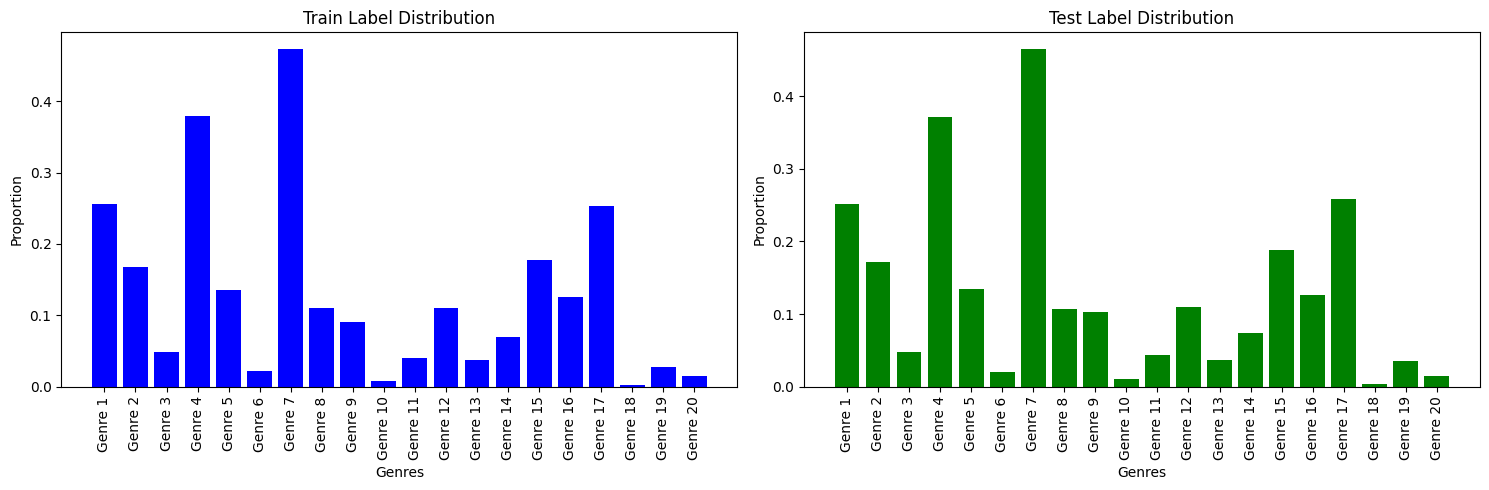

In [ ]:
# Checkpoint
import numpy as np
import matplotlib.pyplot as plt

def label_distribution(y):
    return np.sum(y, axis=0) / y.shape[0]

# Assuming y_train and y_test are already defined
train_distribution = label_distribution(y_train)
test_distribution = label_distribution(y_test)

# Plotting the bar chart
labels = [f"Genre {i+1}" for i in range(len(train_distribution))]  # Replace with actual genre names if available

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution bar chart
ax[0].bar(labels, train_distribution, color='blue')
ax[0].set_title("Train Label Distribution")
ax[0].set_xlabel("Genres")
ax[0].set_ylabel("Proportion")
ax[0].tick_params(axis='x', rotation=90)

# Test label distribution bar chart
ax[1].bar(labels, test_distribution, color='green')
ax[1].set_title("Test Label Distribution")
ax[1].set_xlabel("Genres")
ax[1].set_ylabel("Proportion")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



In [2]:
# It seems that the data has been split balancely.

### 3. VECTORIZE TEXT USING TF-IDF

In [15]:
# TF-IDF for the text

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = vectorizer.transform(X_test)



### 4. MODELLING

### 4.1. RANDOM FOREST

In [ ]:
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')  # You can tune parameters

rf_model = RandomForestClassifier(
    n_estimators=363,             # tambahkan pohon biar hasil lebih stabil
    random_state=42,
    class_weight='balanced',      # penting untuk imbalance
    max_depth=11,                 # cegah overfitting
    min_samples_leaf=8,           # biar pohon lebih smooth
    n_jobs=-1                     # pakai semua core CPU
)
rf_model_multi = MultiOutputClassifier(rf_model)

# Train the model with binarized labels
rf_model_multi.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=11,
                                                       min_samples_leaf=8,
                                                       n_estimators=363,
                                                       n_jobs=-1,
                                                       random_state=42))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 60),
    'min_samples_leaf': randint(1, 10),
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # jumlah kombinasi acak yang akan dicoba
    scoring='f1_micro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train_tfidf, y_train)
best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best params: {'class_weight': 'balanced', 'max_depth': 11, 'min_samples_leaf': 8, 'n_estimators': 363}


In [ ]:
from sklearn.metrics import classification_report

# Prediksi
y_pred_rf = rf_model_multi.predict(X_test_tfidf)

# Evaluasi
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf, target_names=genre_columns))




                 precision    recall  f1-score   support

         Action       0.62      0.60      0.61       122
      Adventure       0.48      0.45      0.47        86
      Animation       0.27      0.13      0.18        23
         Comedy       0.55      0.63      0.59       180
          Crime       0.54      0.46      0.50        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.65      0.64      0.65       225
         Family       0.42      0.31      0.36        52
        Fantasy       0.42      0.30      0.35        50
        Foreign       0.00      0.00      0.00         5
        History       0.36      0.19      0.25        21
         Horror       0.60      0.60      0.60        53
          Music       0.45      0.28      0.34        18
        Mystery       0.39      0.24      0.30        38
        Romance       0.53      0.54      0.54        92
Science.Fiction       0.57      0.44      0.50        63
       Thriller       0.52    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# I adjust the threshold to be 0.3

import numpy as np
from sklearn.metrics import classification_report

# Predict prob
y_pred_proba = rf_model_multi.predict_proba(X_test_tfidf)

y_pred_proba_array = np.array([prob[:, 1] for prob in y_pred_proba]).T  # shape: (n_samples, n_labels)

# Threshold manual
threshold = 0.48
y_pred_thresh = (y_pred_proba_array >= threshold).astype(int)

# Re-evaluate
print(classification_report(y_test, y_pred_thresh, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.51      0.73      0.60       122
      Adventure       0.40      0.51      0.45        86
      Animation       0.26      0.22      0.24        23
         Comedy       0.49      0.79      0.61       180
          Crime       0.47      0.58      0.52        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.58      0.88      0.70       225
         Family       0.36      0.48      0.41        52
        Fantasy       0.40      0.44      0.42        50
        Foreign       0.00      0.00      0.00         5
        History       0.24      0.19      0.21        21
         Horror       0.40      0.75      0.53        53
          Music       0.38      0.28      0.32        18
        Mystery       0.28      0.32      0.30        38
        Romance       0.45      0.67      0.54        92
Science.Fiction       0.49      0.63      0.55        63
       Thriller       0.46    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Observation: the F1 score still 53%

### 4.2. NEURAL NETWORK (MLP)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Create an MLPClassifier model (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Wrap the MLPClassifier in MultiOutputClassifier for multi-label classification
mlp_model_multi = MultiOutputClassifier(mlp_model)

# Train the model on the training data
mlp_model_multi.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                              max_iter=1000, random_state=42))

In [19]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_mlp = np.array([
    estimator.predict_proba(X_test_tfidf)[:, 1]
    for estimator in mlp_model_multi.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [21]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_mlp_val = build_conformal_sets(y_test_probs_mlp, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_mlp_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=0 | Length=0.8707 | Metric=0.4354
Threshold=0.15 | Coverage=0 | Length=0.8823 | Metric=0.4411
Threshold=0.20 | Coverage=0 | Length=0.8904 | Metric=0.4452
Threshold=0.25 | Coverage=0 | Length=0.8974 | Metric=0.4487
Threshold=0.30 | Coverage=0 | Length=0.9029 | Metric=0.4514
Threshold=0.35 | Coverage=0 | Length=0.9077 | Metric=0.4538
Threshold=0.40 | Coverage=0 | Length=0.9121 | Metric=0.4561
Threshold=0.45 | Coverage=0 | Length=0.9159 | Metric=0.4580
Threshold=0.50 | Coverage=0 | Length=0.9192 | Metric=0.4596
Threshold=0.55 | Coverage=0 | Length=0.9220 | Metric=0.4610
Threshold=0.60 | Coverage=0 | Length=0.9254 | Metric=0.4627
Threshold=0.65 | Coverage=0 | Length=0.9291 | Metric=0.4645
Threshold=0.70 | Coverage=0 | Length=0.9317 | Metric=0.4658
Threshold=0.75 | Coverage=0 | Length=0.9351 | Metric=0.4675
Threshold=0.80 | Coverage=0 | Length=0.9389 | Metric=0.4695
Threshold=0.85 | Coverage=0 | Length=0.9450 | Metric=0.4725
Threshold=0.90 | Coverage=0 | Length=0.9

In [17]:
y_pred_nn = mlp_model_multi.predict(X_test_tfidf)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_nn, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.60      0.43      0.50       122
      Adventure       0.55      0.29      0.38        84
      Animation       0.50      0.04      0.08        23
         Comedy       0.64      0.59      0.61       180
          Crime       0.71      0.25      0.37        67
    Documentary       1.00      0.10      0.18        10
          Drama       0.64      0.62      0.63       225
         Family       0.50      0.17      0.26        52
        Fantasy       0.35      0.12      0.18        49
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.70      0.43      0.53        53
          Music       0.50      0.06      0.10        18
        Mystery       0.22      0.05      0.09        37
        Romance       0.59      0.29      0.39        91
Science.Fiction       0.70      0.31      0.43        62
       Thriller       0.55    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# I also try to lower the threshold
import numpy as np
from sklearn.metrics import classification_report

# Ambil probabilitas output
y_pred_proba_nn = mlp_model_multi.predict_proba(X_test_tfidf)

# Gabungkan semua output ke array bentuk (n_samples, n_labels)
y_pred_proba_array_nn = np.array([prob[:, 1] for prob in y_pred_proba_nn]).T

# Tentukan threshold baru (misal 0.3)
threshold = 0.3
y_pred_thresh_nn = (y_pred_proba_array_nn >= threshold).astype(int)

# Evaluasi ulang
print(classification_report(y_test, y_pred_thresh_nn, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.57      0.52      0.54       122
      Adventure       0.60      0.36      0.45        86
      Animation       0.17      0.04      0.07        23
         Comedy       0.63      0.63      0.63       180
          Crime       0.57      0.30      0.39        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.62      0.68      0.65       225
         Family       0.50      0.29      0.37        52
        Fantasy       0.30      0.14      0.19        50
        Foreign       0.00      0.00      0.00         5
        History       0.67      0.10      0.17        21
         Horror       0.63      0.45      0.53        53
          Music       0.67      0.11      0.19        18
        Mystery       0.31      0.11      0.16        38
        Romance       0.57      0.38      0.46        92
Science.Fiction       0.62      0.33      0.43        63
       Thriller       0.52    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# it's also getting better a bit by lowering the threshold

### 4.3. LOG REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Base logistic regression dengan class_weight
base_logreg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)
logreg_multi = MultiOutputClassifier(base_logreg)

# Train
logreg_multi.fit(X_train_tfidf, y_train)



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   multi_class='multinomial'))

In [ ]:

# Predict
y_pred_lr = logreg_multi.predict(X_test_tfidf)

# evaluation
print(classification_report(y_test, y_pred_lr, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.61      0.66      0.63       122
      Adventure       0.54      0.42      0.47        86
      Animation       0.33      0.22      0.26        23
         Comedy       0.65      0.68      0.66       180
          Crime       0.53      0.43      0.48        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.66      0.68      0.67       225
         Family       0.53      0.46      0.49        52
        Fantasy       0.50      0.38      0.43        50
        Foreign       0.00      0.00      0.00         5
        History       0.44      0.19      0.27        21
         Horror       0.70      0.66      0.68        53
          Music       0.55      0.33      0.41        18
        Mystery       0.36      0.24      0.29        38
        Romance       0.54      0.51      0.53        92
Science.Fiction       0.70      0.52      0.60        63
       Thriller       0.60    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# lowering the threshold

import numpy as np

# Get probability
y_pred_proba_lr = logreg_multi.predict_proba(X_test_tfidf)

y_pred_proba_array_lr = np.array([prob[:, 1] for prob in y_pred_proba_lr]).T

# New threshold
threshold = 0.4
y_pred_thresh_lr = (y_pred_proba_array_lr >= threshold).astype(int)

# Re-evaluate
print(classification_report(y_test, y_pred_thresh_lr, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.51      0.79      0.62       122
      Adventure       0.43      0.63      0.51        86
      Animation       0.32      0.30      0.31        23
         Comedy       0.55      0.83      0.66       180
          Crime       0.51      0.64      0.57        67
    Documentary       0.00      0.00      0.00        10
          Drama       0.60      0.89      0.72       225
         Family       0.42      0.60      0.49        52
        Fantasy       0.47      0.46      0.46        50
        Foreign       0.00      0.00      0.00         5
        History       0.35      0.38      0.36        21
         Horror       0.45      0.74      0.56        53
          Music       0.44      0.44      0.44        18
        Mystery       0.31      0.37      0.34        38
        Romance       0.45      0.73      0.56        92
Science.Fiction       0.48      0.63      0.54        63
       Thriller       0.51    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# CONCLUSION: The best model is Log Regression